[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ZiyangS/AI_3300_ML/blob/main/Titanic_cls.ipynb)

# Classification for Titanic Dataset

In this notebook, we build a complete data science pipeline for the Titanic classification task. The goal is to predict the target label survived given a passenger's profile.

We load the dataset, define input features and labels, preprocess the data, split it into training and test sets, and train and evaluate a scikit-learn Logistic Regression classifier.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

# Titanic Dataset

We use the Titanic passenger dataset to build a binary classification model.

- **Label (target):** `survived`  
  - `1` = survived, `0` = did not survive

- **Features (inputs):** all remaining columns except `survived`, including:
  - **Ticket / class:** `pclass`, `class`, `fare`
  - **Demographics:** `sex`, `age`, `who`, `adult_male`
  - **Family / group:** `sibsp`, `parch`, `alone`
  - **Travel info:** `embarked`, `embark_town`, `deck`
  - **(Remove) Potential leakage:** `alive`

> Note: `alive` is essentially a yes/no version of `survived`, so it should be removed to avoid **data leakage**.

In [2]:
# Load data
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"
df = pd.read_csv(url)
print(df.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [3]:
# display all columns
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [24]:
# Define the target label (binary outcome: 1 = survived, 0 = did not survive)
target_col = "survived"
y = df[target_col].astype(int).values
y.shape

(891,)

In [5]:
# Build input features by dropping the target label column.
X_df = df.drop(columns=[target_col]).copy()

# Drop columns that are not used as features.
drop_if_exist = ["Name", "Ticket", "Cabin"]
for c in drop_if_exist:
    if c in X_df.columns:
        X_df = X_df.drop(columns=[c])
print(X_df.columns)

# Drop 'alive' to avoid label leakage, since it closely matches the target 'survived'.
X_df = X_df.drop(columns=["alive"])

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class',
       'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'],
      dtype='object')


In [6]:
# Split features into categorical vs. numerical based on data types.
# Discrete: category and bool
# Continuous: numeric
cat_cols = X_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X_df.columns if c not in cat_cols]

In [7]:
# Categorical = category/bool (discrete values)
cat_cols

['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alone']

In [8]:
# Numerical = numeric (continuous values)
num_cols

['pclass', 'age', 'sibsp', 'parch', 'fare']

In [9]:
# Encode categorical features as 1, 2, 3, ...
X_proc = X_df.copy()  # Work on a copy so we don't modify the original raw features.
print('----------------------before processing----------------------')
print(X_proc.head())

# Convert each categorical column to integer codes
for c in cat_cols:
    # Map each distinct category (e.g., 'male', 'female') to an integer code: 0, 1, 2, ...
    # Missing values (NaN) are encoded as -1.
    codes = pd.Categorical(X_proc[c]).codes

    # Shift codes so categories start at 1 (therefore missing becomes 0).
    X_proc[c] = codes + 1

    # Convert the missing code (0) back to NaN so we can impute it later.
    X_proc.loc[X_proc[c] == 0, c] = np.nan
print('----------------------after processing----------------------')
print(X_proc.head())

----------------------before processing----------------------
   pclass     sex   age  sibsp  parch     fare embarked  class    who  \
0       3    male  22.0      1      0   7.2500        S  Third    man   
1       1  female  38.0      1      0  71.2833        C  First  woman   
2       3  female  26.0      0      0   7.9250        S  Third  woman   
3       1  female  35.0      1      0  53.1000        S  First  woman   
4       3    male  35.0      0      0   8.0500        S  Third    man   

   adult_male deck  embark_town  alone  
0        True  NaN  Southampton  False  
1       False    C    Cherbourg  False  
2       False  NaN  Southampton   True  
3       False    C  Southampton  False  
4        True  NaN  Southampton   True  
----------------------after processing----------------------
   pclass  sex   age  sibsp  parch     fare  embarked  class  who  adult_male  \
0       3  2.0  22.0      1      0   7.2500       3.0    3.0  2.0         2.0   
1       1  1.0  38.0      1   

In [10]:
# Ensure numeric columns are numeric
for c in num_cols:
    X_proc[c] = pd.to_numeric(X_proc[c], errors="coerce")

In [11]:
# Impute missing values column-by-column.
for c in X_proc.columns:
    if c in num_cols:
        # Continuous (numeric) feature: fill missing values with the column mean (simple baseline).
        mean_val = X_proc[c].mean()
        X_proc[c] = X_proc[c].fillna(mean_val)
    else:
        # Categorical feature (already encoded as integer codes): fill missing with the mode (most frequent code).
        # We avoid mean-imputing category codes because the "average code" can be fractional and not a valid category.
        # If multiple modes exist, take the first one.
        mode_val = X_proc[c].mode(dropna=True)[0]
        X_proc[c] = X_proc[c].fillna(mode_val)

In [12]:
# Convert to numpy. Right now, every input feature is a scalar value.
X = X_proc.values.astype(float)

In [13]:
X.shape

(891, 13)

In [14]:
# Train / test split with a ratio of 80% / 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

In [15]:
X_train.shape

(712, 13)

In [16]:
X_test.shape

(179, 13)

In [17]:
# Standardize features (z-score normalization)
# Idea: rescale each feature to have mean = 0 and standard deviation = 1 on the training set.
# Question: many models (including Logistic Regression) train more stably when features are on a similar scale?
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # learn mean/std from training data, then transform training data
X_test = scaler.transform(X_test)        # apply the same transformation to test data

## Training the model

In [18]:
# Train scikit-learn Logistic Regression on the training set
clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Classification accuracy

In [19]:
# evaluate
y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)

print("=== Evaluation on Test Set ===")
print(f"Accuracy: {acc:.4f}")

=== Evaluation on Test Set ===
Accuracy: 0.8268


In [20]:
y_prob[0:5]

array([0.04871444, 0.06047315, 0.1334639 , 0.03375655, 0.65200672])

In [21]:
y_pred[0:5]

array([0, 0, 0, 0, 1])

## Feature Relation Analysis


In [22]:
# Inspect model parameters (feature effects)
#   - intercept_: bias term
#   - coef_: weight for each feature (after preprocessing / scaling)

feature_names = X_proc.columns.tolist()

bias = float(clf.intercept_[0])          # scalar intercept
coef = clf.coef_.reshape(-1)             # shape: (num_features,)

coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values(
    "coef", ascending=False
)

print("Intercept (bias):", bias)
print("\nCoefficients (sorted by effect):")
print(coef_df.to_string(index=False))

Intercept (bias): -0.6778770112479217

Coefficients (sorted by effect):
    feature      coef
       deck  0.210052
       fare  0.135143
        who  0.027137
   embarked -0.099126
embark_town -0.099126
        sex -0.151799
      alone -0.177922
      parch -0.257978
        age -0.270941
      class -0.409050
     pclass -0.409050
      sibsp -0.517253
 adult_male -1.294700


<Figure size 640x480 with 0 Axes>

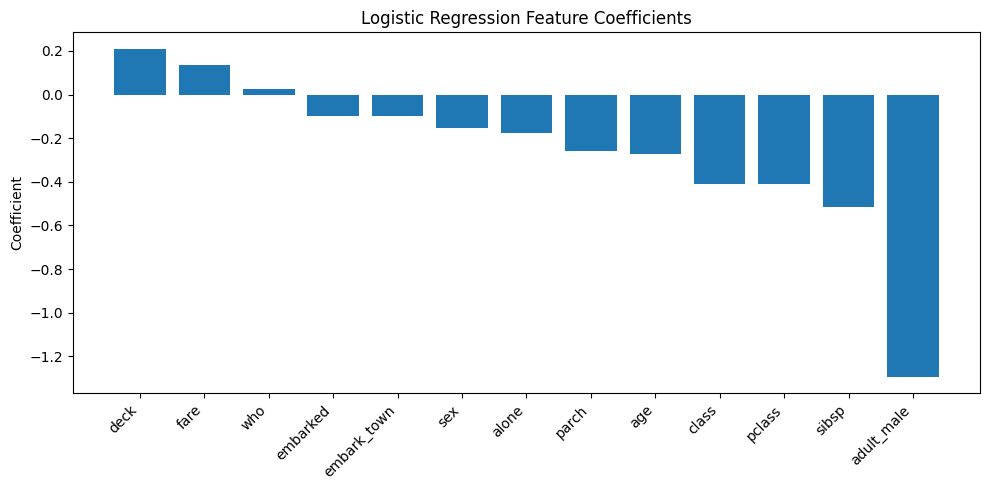

In [23]:
# Visualize Logistic Regression coefficients
# (Positive coef -> increases predicted survival; Negative coef -> decreases it)
plt.clf()
plt.figure(figsize=(10, 5))

plt.bar(coef_df["feature"], coef_df["coef"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Coefficient")
plt.title("Logistic Regression Feature Coefficients")

plt.tight_layout()
plt.savefig("logreg_coefficients.png", bbox_inches="tight", dpi=300)